In [2]:
from qiskit import *
import numpy as np
import matplotlib as mpl
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.tools.monitor import job_monitor

state_sim = Aer.get_backend('statevector_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')
unitary_sim = Aer.get_backend('unitary_simulator')

qiskit.__qiskit_version__   #developed in q0.14.0, q-terra0.11.0

{'qiskit-terra': '0.11.0',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.4.4',
 'qiskit-aqua': '0.6.1',
 'qiskit': '0.14.0'}

In [3]:
# Definition of c_Increment, c_Decrement gates

def increment(qc,qr):
    """controlled-increment gate, cf. PhysRevA.72.032329"""
    for i in range(num_qubits - 1):
        qc.mct(qr[0:num_qubits - 1 - i], qr[num_qubits - 1 - i] , qr_aux)
        
def decrement(qc,qr):
    """controlled-decrement gate, cf. PhysRevA.72.032329"""
    for i in range(num_qubits - 1):
        qc.mct(qr[0:i+1], qr[i+1], qr_aux)
        
# Definition of QW cycle

def quantum_walk(qc,qr,num_steps):
    """implement DTQW on a previously defined circuit and register cf. PhysRevA.72.032329"""
    for i in range(num_steps):
        qc.h(qr[0])
        increment(qc,qr)
        qc.x(qr[0])
        decrement(qc,qr)
        qc.x(qr[0])
        
def get_tot_gates(qc):
    """get the total number of basic gates of a circuit"""
    tot_gates = 0

    for key in qc.decompose().count_ops():
        tot_gates = tot_gates + qc.decompose().count_ops()[key]
    
    return tot_gates

def barrier(qc,qr,qr_aux):
    """barrier gate over all quantum registers, including aux if it exists"""
    if qr_aux != None:
        qc.barrier(qr,qr_aux)
    else:
        qc.barrier(qr)

In [6]:
# Total number of qubits (nodes + coin)
num_qubits = 6

# Define qRegister and qCircuit
qr = QuantumRegister(num_qubits, 'qr')
cr = ClassicalRegister(num_qubits - 1, 'cr')

# We need (num_control - 2) aux qubits for mct
if num_qubits > 3:
    qr_aux = QuantumRegister(num_qubits - 3, 'aux')
    qc = QuantumCircuit(qr,qr_aux,cr)
else:
    qr_aux = None
    qc = QuantumCircuit(qr,cr)


# Initialization for symmetric state 1/sqrt(2) [|0> + i|1>] of coin

qc.h(qr[0])
qc.s(qr[0])

barrier(qc,qr,qr_aux)

# Initialization for middle state |1000...> of nodes 

qc.x(qr[num_qubits - 1])

barrier(qc,qr,qr_aux)

# Running the QW

quantum_walk(qc,qr,12)

barrier(qc,qr,qr_aux)

qc.measure(qr[1:num_qubits],cr)

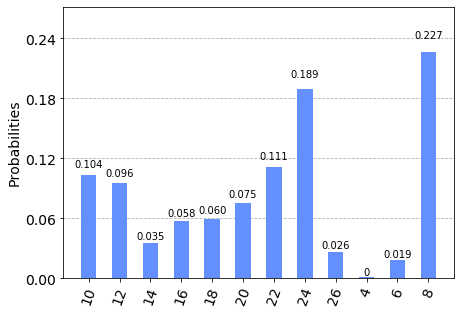

In [7]:
# Execute the circuit

job = execute(qc, backend=qasm_sim)

results_dict = job.result().get_counts()

# Convert the results to decimal value of cReg and plot

results_dec = {}
for key, value in results_dict.items():
    results_dec[str(int(key,2))] = value
    
plot_histogram(results_dec)